In [738]:
# The following code references from 
# https://github.com/yhat/DataGotham2013/tree/master/notebooks
import pandas as pd
import numpy as np
import os
import math
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.svm import SVC
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
#Global Variable:
DEP_VAR='SeriousDlqin2yrs'
LEAD_VAR = 2


In [611]:
def read(file_name):
    '''
    Read/load data file that is put in the default folder "data"
    Input: 
        file_name(String)
    Return:
        pd dataframe
    '''
    file_path = 'data/'+ file_name
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".csv":
        df = pd.read_csv(file_path)
    elif ext == ".xls":
        df = pd.read_excel(file_path)
    else:
        raise ValueError('{file} is an unsupported file format.'.format(file=file_path))
    return df

In [585]:
df = read("credit-data.csv")
# Adjust data type -percentage
df.RevolvingUtilizationOfUnsecuredLines = df.RevolvingUtilizationOfUnsecuredLines*100
df.DebtRatio = df.DebtRatio*100
df.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,76.612661,45,60644,2,80.298213,9120.0,13,0,6,0,2.0
1,2,0,95.715102,40,60637,0,12.187620,2600.0,4,0,0,0,1.0
2,3,0,65.818014,38,60601,1,8.511337,3042.0,2,1,0,0,0.0
3,4,0,23.380978,30,60601,0,3.604968,3300.0,5,0,0,0,0.0
4,5,0,90.723940,49,60625,1,2.492570,63588.0,7,0,1,0,0.0


In [586]:
def explore(df):
    '''
    Generate summary statisitcs and list of features(exclude dependent var)
    for the whole dataset
    Return:
        d: a dictionary contains summary statistics and list of feature for whole dataset
    '''
    d = {}
    summary = df.describe()
    features = np.array(list(df)[LEAD_VAR:])
    d["summary"] = summary
    d["features"] = features
    
    return d
    
def explore_var(df,var,graph_type):
    '''
    Generate distribution graph for specific variable
    Input:
        df: pd dataframe
        variable(string): the variable/attribute you want to explore
        graph_type(string): the type of graph you want to draw
    Return:
        d_var: a dictionary contains distribution for the selected attribute
        and the corresponding garph and feature list for that attribute. 
    '''
    d_var = {}
    cols = [var, DEP_VAR]
    var_mean = df[cols].groupby(var).mean()
    graph = var_mean.plot(kind=graph_type,use_index=False,figsize=(8,4))
    
    d_var["distribution"] = var_mean
    d_var["graph"] = graph
    
    return d_var

In [587]:
summary = explore(df)["summary"]
features = explore(df)["features"] 

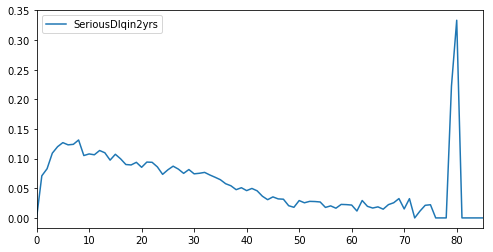

In [588]:
age_graph = explore_var(df,'age','line')["graph"]

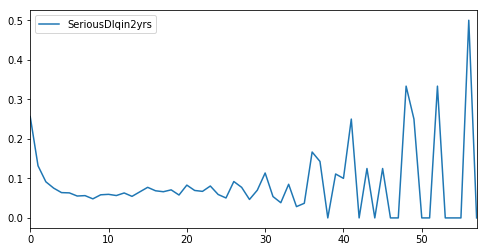

In [589]:
loan_graph = explore_var(df,'NumberOfOpenCreditLinesAndLoans','line')["graph"]

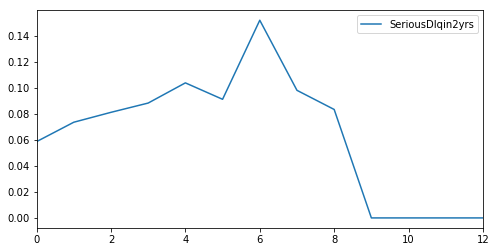

In [590]:
dependent_graph = explore_var(df,'NumberOfDependents','line')["graph"]

In [591]:
def check_missing_data(df):
    """
    Calculates how many values for each variable is null for a given DataFrame
    """ 
    df_lng = pd.melt(df) #Convert to long data
    null_variables = df_lng.value.isnull()
    
    return pd.crosstab(df_lng.variable, null_variables)
check_missing_data(df)

value,False,True
variable,,
DebtRatio,150000,0
MonthlyIncome,120269,29731
NumberOfDependents,146076,3924
NumberOfOpenCreditLinesAndLoans,150000,0
NumberOfTime30-59DaysPastDueNotWorse,150000,0
NumberOfTime60-89DaysPastDueNotWorse,150000,0
NumberOfTimes90DaysLate,150000,0
NumberRealEstateLoansOrLines,150000,0
PersonID,150000,0


In [592]:
def clean(df,var,fill_method):
    '''
    In this assignment,this function is limited to fill in missing value for variables that have
    missing value showed in last function 'check_missing_data'.
    Input:
        variable(string): the variable you want to fill in missing value (indicated in'check_missing_data' )
        fill_method(string): the method to fill in NA values. Avaliable methods are:
                             'drop', 'mean','zero',pad','ffill'.
    Return:
        df after cleaning
    more methods: http://pandas.pydata.org/pandas-docs/stable/missing_data.html#cleaning-filling-missing-data
    '''
    if fill_method == "zero":
        df[var] = df[var].fillna(0)
    elif fill_method == "mean":
        df[var] = df[var].fillna(df[var].mean())
    elif fill_method == "drop":
        df[var] = df[var].fillna(0)
    elif fill_method == "pad" or fill_method == "ffill":
        df[var] = df[var].fillna(method=fill_method)
    else: 
        raise ValueError('{method} not avaliable'.format(method=fill_method))
    
    return df

#Sample use:
#df = clean(df,'NumberOfDependents','zero')
#df = clean(df,'MonthlyIncome','mean')
#check_missing_data(df)

In [593]:
df = clean(df,'NumberOfDependents','zero')
df = clean(df,'MonthlyIncome','mean')
check_missing_data(df)

value,False
variable,
DebtRatio,150000
MonthlyIncome,150000
NumberOfDependents,150000
NumberOfOpenCreditLinesAndLoans,150000
NumberOfTime30-59DaysPastDueNotWorse,150000
NumberOfTime60-89DaysPastDueNotWorse,150000
NumberOfTimes90DaysLate,150000
NumberRealEstateLoansOrLines,150000
PersonID,150000


In [618]:
def generate_bins(df,var,size):
    '''
    
    '''
    lb = int(math.floor(df[var].describe()[3]))
    lb2 = int(math.floor(df[var].describe()[4]))
    ub = int(math.ceil(df[var].describe()[7]))
    ub2_temp = int(math.ceil(df[var].describe()[6]))
    bins = int(math.ceil((ub2_temp-lb2)/size))
    ub2 = int(lb2+size*(bins))
    bins = [lb] + range(lb2,ub2+size,size) + [ub]
    return bins

def build_category(df,var,bins):
    '''
    Discretize a continous variable
    '''
    new_name = var + '_bucket'
    df[new_name] = pd.cut(df[var], bins, labels=False,include_lowest=True)
    return df

def create_dummy(df,var):
    '''
    '''
    dummy_df = pd.get_dummies(df[var],prefix=[var])
    return dummy_df

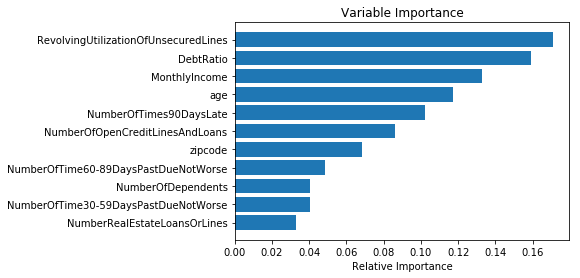

In [596]:
important_feature = find_features (df, features)   

In [612]:
UnsecuredLines_bins = generate_bins(df,'RevolvingUtilizationOfUnsecuredLines',5)
DebtRatio_bins = generate_bins(df,'DebtRatio',10)
income_bins = generate_bins(df,'MonthlyIncome',500)
age_bins = generate_bins(df,'age',5)

df = build_category(df,'RevolvingUtilizationOfUnsecuredLines',UnsecuredLines_bins)
df = build_category(df,'DebtRatio',DebtRatio_bins)
df = build_category(df,'MonthlyIncome',income_bins)
df = build_category(df,'age',age_bins)

In [619]:
df.describe()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines_bucket,DebtRatio_bucket,MonthlyIncome_bucket,age_bucket
count,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438e+02,52.295207,60648.810013,0.421033,3.530051e+04,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.737413,4.860927,3.414867,4.042900,2.553033
std,43301.414527,0.249746,2.497554e+04,14.771866,56.748197,4.192781,2.037819e+05,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.107021,4.443836,3.107104,2.869389,1.971429
min,1.000000,0.000000,0.000000e+00,0.000000,60601.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,2.986744e+00,41.000000,60625.000000,0.000000,1.750738e+01,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,75000.500000,0.000000,1.541807e+01,52.000000,60629.000000,0.000000,3.665078e+01,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,3.000000,2.000000,6.000000,3.000000
75%,112500.250000,0.000000,5.590462e+01,63.000000,60644.000000,0.000000,8.682538e+01,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,11.000000,7.000000,7.000000,5.000000
max,150000.000000,1.000000,5.070800e+06,109.000000,60804.000000,98.000000,3.296640e+07,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,11.000000,8.000000,7.000000,5.000000


In [625]:
DebtRatio_dummy = create_dummy(df,'DebtRatio_bucket')
income_dummy = create_dummy(df,'MonthlyIncome_bucket')
age_dummy = create_dummy(df,'age_bucket')

In [626]:
df_new = pd.concat([df, DebtRatio_dummy,income_dummy,age_dummy], axis=1)

In [630]:
df_new.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,...,['MonthlyIncome_bucket']_4,['MonthlyIncome_bucket']_5,['MonthlyIncome_bucket']_6,['MonthlyIncome_bucket']_7,['age_bucket']_0,['age_bucket']_1,['age_bucket']_2,['age_bucket']_3,['age_bucket']_4,['age_bucket']_5
0,1,1,76.612661,45,60644,2,80.298213,9120.0,13,0,...,0,0,0,1,0,1,0,0,0,0
1,2,0,95.715102,40,60637,0,12.187620,2600.0,4,0,...,0,0,0,0,1,0,0,0,0,0
2,3,0,65.818014,38,60601,1,8.511337,3042.0,2,1,...,0,0,0,0,1,0,0,0,0,0
3,4,0,23.380978,30,60601,0,3.604968,3300.0,5,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0,90.723940,49,60625,1,2.492570,63588.0,7,0,...,0,0,0,1,0,0,1,0,0,0


In [697]:
selected_features = [
#  'SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
#  'zipcode',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome']
#  'NumberOfOpenCreditLinesAndLoans',
#  'NumberOfTimes90DaysLate',
#  'NumberRealEstateLoansOrLines',
#  'NumberOfTime60-89DaysPastDueNotWorse',
#  'NumberOfDependents',
#  'RevolvingUtilizationOfUnsecuredLines_bucket',
#  'DebtRatio_bucket',
#  'MonthlyIncome_bucket',
#  'age_bucket']


In [751]:
def form_train_test(df,selected_features,test_size):
    X = df[selected_features].head(n=1000000)
    y = df[DEP_VAR].head(n=1000000)
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [761]:
(X_train, X_test, y_train, y_test) = form_train_test(df,selected_features,0.7)

def classifier(classifier_type,X_train, X_test, y_train):
    '''
    '''
    if classifier_type == "KNN":
        clf = KNeighborsClassifier(n_neighbors=13,
                                   metric='minkowski', 
                                   weights='distance')
    elif classifier_type == "Logit":
        clf = LogisticRegression()
    elif classifier_type == "Tree":
        clf = tree.DecisionTreeClassifier()
    elif classifier_type == "GB":
        clf =GradientBoostingClassifier()
    else:
        raise ValueError('{c_type} not avaliable'.format(c_type=classifier_type))
        
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    probs = clf.predict_proba(X_test)

    return (y_hat, probs)

In [767]:
(yhat, probs) = classifier("GB",X_train, X_test, y_train)

In [771]:
def evaluate(y_test, yhat):
    confusion_matrix  = pd.crosstab(yhat, y_test, rownames=["Actual"], colnames=["Predicted"])
    report = classification_report(y_test, yhat, labels=[0, 1])
    return (confusion_matrix , report)
    

In [772]:
(confusion_matrix, report) = evaluate(y_test, yhat)
confusion_matrix

Predicted,0,1
Actual,,
0,97569,6415
1,475,541


In [774]:
print(report)

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     98044
          1       0.53      0.08      0.14      6956

avg / total       0.91      0.93      0.91    105000

